In [1]:
from __future__ import annotations
from typing import List

import os
import re
import h5py
import numpy as np
import configparser
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Constant

In [2]:
HEADER_SIZE = 1159544
METADATA_SIZE = 554
SV_SCAN_SIZE = 25930
VOC_SCAN_SIZE = 17290
BB_SCAN_SIZE = 8650
TRANSPORT_BLOCK_SIZE = 9216
KM_DATA_SIZE = 2304

SYNCHROSERIES_SIZE = 10

SENSORS_COUNT = 40

# Colibrators
SV_BLOCK_SIZE = 216
SV_DN_INLINE_COUNT = 144

VOC_BLOCK_SIZE = 144
VOC_DN_INLINE_COUNT = 96

BB_BLOCK_SIZE = 72
BB_DN_INLINE_COUNT = 48

In [3]:
config = configparser.ConfigParser()
config.read('file_paths.ini')
config.sections()

[]

In [4]:
# File paths for FengYun-3E data.
FY3E_DATA_FOLDERS_LOCATION = config['FY3']['FY3E_MAIN_DATA_LOCATION']
FY3E_RAW_DATA_LOCATION = config['FY3']['FY3E_RAW_DATA_LOCATION']
FY3E_L0_DATA_LOCATION = config['FY3']['FY3E_L0_DATA_LOCATION']
FY3E_L1_DATA_LOCATION = config['FY3']['FY3E_L1_DATA_LOCATION']
FY3E_L1_GOE_DATA_LOCATION = config['FY3']['FY3E_L1_GOE_DATA_LOCATION']
FY3E_L1_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_IMAGE_DATA_LOCATION']
FY3E_L1_GEOREF_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_GEOREF_IMAGE_DATA_LOCATION']

In [5]:
fy3e_L0_files_paths = [FY3E_L0_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L0_DATA_LOCATION)]
fy3e_l1_geo_files_paths = [FY3E_L1_GOE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_GOE_DATA_LOCATION)]
fy3e_l1_image_files_paths = [FY3E_L1_IMAGE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_IMAGE_DATA_LOCATION)]

print('L0 files -', fy3e_L0_files_paths)
print()
print('GEO files -', fy3e_l1_geo_files_paths)
print()
print('Image files -', fy3e_l1_image_files_paths)

L0 files - ['E:/Satellite data/FY-3E/L0/Y3E_08534_230226070855_7860R_MERSI.DAT']

GEO files - ['E:/Satellite data/FY-3E/L1/geo/FY3E_MERSI_GRAN_L1_20230228_2215_GEOQK_V0.HDF']

Image files - ['E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0435_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0935_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0520_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0840_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0845_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1020_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1745_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_2100_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_2250_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230228_2215_0250

## Utilities

In [4]:
def find_synchroseries(byte_line: bytes) -> np.array:
    synchroseries = b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d'
    return np.array([i.start() for i in re.finditer(synchroseries, byte_line)])

In [5]:
def read_uint12(data_chunk):
    data = np.frombuffer(data_chunk, dtype=np.uint8)
    fst_uint8, mid_uint8, lst_uint8 = np.reshape(data, (data.shape[0] // 3, 3)).astype(np.uint16).T
    fst_uint12 = (fst_uint8 << 4) + (mid_uint8 >> 4)
    snd_uint12 = ((mid_uint8 % 16) << 8) + lst_uint8
    
    return np.reshape(np.concatenate((fst_uint12[:, None], snd_uint12[:, None]), axis=1), 2 * fst_uint12.shape[0])

In [6]:
def parse_telemetry_data(data: list, scan_size: int, block_size: int, dn_inline_coun: int) -> List[np.array, np.array, np.array]:
    b6_data = np.zeros((500, SENSORS_COUNT, dn_inline_coun))
    b7_data = np.zeros((500, SENSORS_COUNT, dn_inline_coun))
    km_data = np.zeros((500, SENSORS_COUNT, dn_inline_coun))
    
    for i, block_all in enumerate(data):
        block_all_no_synh = block_all[SYNCHROSERIES_SIZE:]
        
        blocks = []
        for block_index in range(0, scan_size - SYNCHROSERIES_SIZE, block_size):
            blocks.append(read_uint12(block_all_no_synh[block_index:block_index + block_size]))

        b6_data[i] = blocks[:SENSORS_COUNT]
        b7_data[i] = blocks[SENSORS_COUNT:SENSORS_COUNT * 2]
        km_data[i] = blocks[SENSORS_COUNT * 2:SENSORS_COUNT * 3]

    return b6_data, b7_data, km_data

In [7]:
def mean_all_data(data: np.array) -> np.array:
    data_1_2_mirrors = np.stack([data[::2], data[1::2]])

    return np.full(2, np.mean(data_1_2_mirrors))

In [8]:
def mean_by_sensor_data(data: np.array) -> np.array:
    data_1_2_mirrors = np.stack([data[::2], data[1::2]])
    
    return np.mean(data_1_2_mirrors, axis=(1, 3))

In [9]:
def coeff_calulation(mean_all_1: np.array, mean_all_2: np.array, mean_by_sensor_1: np.array, mean_by_sensor_2: np.array) -> List[float, float]:
    alpha = (mean_all_2[..., None] - mean_all_1[..., None]) / (mean_by_sensor_2 - mean_by_sensor_1)
    beta = mean_all_1[..., None] - alpha * mean_by_sensor_1

    return alpha, beta

In [10]:
def apply_coeff_for_image(data: np.array, alpha: float, beta: float) -> np.array:
    data_corrected = np.zeros(data.shape)

    for i in range(data.shape[0]):
        data_corrected[i] = np.round(alpha[(i // 40) % 2][i % 40] * data[i] + beta[(i // 40) % 2][i % 40])

    return data_corrected

In [11]:
def apply_coeff_for_telemetry(data: np.array, alpha: float, beta: float) -> np.array:
    data_corrected = np.zeros(data.shape)

    for i in range(data.shape[0]):
        data_corrected[i] = alpha[..., None][(i // 40) % 2] * data[i] + beta[..., None][(i // 40) % 2]

    return data_corrected

## Parsing data

In [555]:
l0_data = open('./data/Y3E_08534_230226070855_7860R_MERSI.DAT', 'br')

data = l0_data.read(HEADER_SIZE)

section_1, section_2 = [], []
section_3, section_4, section_5, section_6, section_7 = [], [], [], [], []

data2_agg, data3_agg, data4_agg, data5_agg = [], [], [], []

for _ in range(500):
    data2 = l0_data.read(METADATA_SIZE)
    data2_agg.append(data2)

    data3 = l0_data.read(SV_SCAN_SIZE)
    data3_agg.append(data3)

    data4 = l0_data.read(VOC_SCAN_SIZE)
    data4_agg.append(data4)

    data5 = l0_data.read(BB_SCAN_SIZE)
    data5_agg.append(data5)
    
    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        section_1.append(read_uint12(data))

    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        section_2.append(read_uint12(data))
        
    for i in range(SENSORS_COUNT):
        data = l0_data.read(SYNCHROSERIES_SIZE)
        data = l0_data.read(TRANSPORT_BLOCK_SIZE)
        
        section_3.append(read_uint12(data[:KM_DATA_SIZE]))
        section_4.append(read_uint12(data[KM_DATA_SIZE:KM_DATA_SIZE * 2]))
        section_5.append(read_uint12(data[KM_DATA_SIZE * 2:KM_DATA_SIZE * 3]))
        section_6.append(read_uint12(data[KM_DATA_SIZE * 3:KM_DATA_SIZE * 4]))

b6_image = np.array(section_1)
b7_image = np.array(section_2)
km_1_image = np.array(section_3)
km_2_image = np.array(section_4)
km_3_image = np.array(section_5)
km_4_image = np.array(section_6)

In [686]:
import struct
import datetime

In [580]:
frame_count = struct.unpack('i', data2_agg[0][:4])[0]
day_count = datetime.date(2000, 1, 1) + datetime.timedelta(days=struct.unpack('H', data2_agg[0][8:10])[0])
time_interval = struct.unpack('I', data2_agg[0][10:14])[0]
time_count = struct.unpack('Q', data2_agg[0][14:22])[0]


(826672,)

In [737]:
cal_signal_dn = np.zeros(5, dtype=np.uint16)
bracket_calibrator_temp_dn = np.zeros(2, dtype=np.uint16)
voc_temp_dn = 0
cool_temp_voltage_dn = np.zeros(3, dtype=np.uint16)
instrument_status_records = np.zeros(3, dtype=np.uint16)
status_telemetry = np.zeros(2, dtype=np.uint16)
k_mirror_motor_temp_dn = np.zeros(4, dtype=np.uint16)
main_mirror_temp_dn = 0
refl_mirror_temp_dn = 0
vis_detector_temp_dn = 0
near_ir_detector_temp_dn = 0
swir_drv_temp_dn = 0
vis_drv_temp_dn = 0
ir_drv_temp_dn = np.zeros(2, dtype=np.uint16)
obs_mode_voc = np.zeros(3, dtype=np.uint16)
bb_temp_cnt = np.zeros(7, dtype=np.uint16)
scans_type = 0
obs_mode = 0


telemetry_info = data2_agg[1][0x43:0x43 + 0x1e3]

buffer_17 = telemetry_info[0x3f:]
cal_signal_dn[:2] = read_uint12(buffer_17[:3])

buffer_1 = buffer_17[0x3:]
cal_signal_dn[2:4] = read_uint12(buffer_1[:3])

buffer_2 = buffer_1[0x3:]
cal_signal_dn[4], bracket_calibrator_temp_dn[0] = read_uint12(buffer_2[:3])
bracket_calibrator_temp_dn[1], voc_temp_dn = read_uint12(buffer_2[3:6])

buffer_3 = telemetry_info[0x4b:]
cool_temp_voltage_dn[:2] = read_uint12(buffer_3[:3])

buffer_4 = buffer_3[0x3:]
cool_temp_voltage_dn[2], instrument_status_records[0] = read_uint12(buffer_4[:3])

buffer_5 = buffer_4[0x3:]
instrument_status_records[1], status_telemetry[0] = read_uint12(buffer_5[:3])
status_telemetry[1], _ = read_uint12(buffer_5[3:6])

buffer_6 = telemetry_info[0x54:]
k_mirror_motor_temp_dn[:2] = read_uint12(buffer_6[:3])

buffer_7 = buffer_6[0x3:]
k_mirror_motor_temp_dn[2:4] = read_uint12(buffer_7[:3])

buffer_8 = buffer_7[0x3:]
main_mirror_temp_dn, refl_mirror_temp_dn = read_uint12(buffer_8[:3])

buffer_9 = buffer_8[0x3:]
vis_detector_temp_dn, near_ir_detector_temp_dn = read_uint12(buffer_9[:3])

buffer_10 = buffer_9[0x3:]
swir_drv_temp_dn, vis_drv_temp_dn = read_uint12(buffer_10[:3])

buffer_11 = buffer_10[0x3:]
ir_drv_temp_dn[:] = read_uint12(buffer_11[:3])

buffer_12 = buffer_11[0x3:]
instrument_status_records[2], obs_mode_voc[0] = read_uint12(buffer_12[:3])
obs_mode_voc[1:] = read_uint12(buffer_12[3:6])

buffer_14 = telemetry_info[0x1d7:]
bb_temp_cnt[:2] = read_uint12(buffer_14[:3])

buffer_15 = buffer_14[0x3:]
bb_temp_cnt[2:4] = read_uint12(buffer_15[:3])

buffer_16 = buffer_15[0x3:]
bb_temp_cnt[4:6] = read_uint12(buffer_16[:3])
bb_temp_cnt[6], flags = read_uint12(buffer_16[3:6])
scans_type = flags & 1
obs_mode = ((flags & 0x10) >> 4)
obs_mode = obs_mode & 1, (obs_mode >> 1) & 1, (obs_mode >> 2) & 1, (obs_mode >> 3) & 1

print(bb_temp_cnt)

[741 726 809 743 718 822 748]


In [614]:
struct.unpack('d', data2_agg[0][4:12])

(6.581248584446291e+285,)

In [612]:
print(data2_agg[0][16:22])
print(data2_agg[1][16:22])
print(data2_agg[2][16:22])
print(data2_agg[400][16:22])

b'\x00\x00\x00\x00\x00\x00'
b'\x00\x00\x00\x00\x00\x00'
b'\x00\x00\x00\x00\x00\x00'
b'\x00\x00\x00\x00\x00\x00'


In [556]:
d = 2

In [557]:
b6_image = b6_image[:b6_image.shape[0] // d, :]

In [558]:
data3_agg = data3_agg[: len(data3_agg) // d]
data4_agg = data4_agg[: len(data4_agg) // d]
data5_agg = data5_agg[: len(data5_agg) // d]

### Space view data

In [559]:
sv_b6_data, sv_b7_data, sv_km_data = parse_telemetry_data(data3_agg, SV_SCAN_SIZE, SV_BLOCK_SIZE, SV_DN_INLINE_COUNT)

In [560]:
sv_b6_data = sv_b6_data[2:]

In [561]:
sv_b6_mean_all = mean_all_data(sv_b6_data)
sv_b6_sensors_mean = mean_by_sensor_data(sv_b6_data)

### Black body data

In [562]:
bb_b6_data, bb_b7_data, bb_km_data = parse_telemetry_data(data5_agg, BB_SCAN_SIZE, BB_BLOCK_SIZE, BB_DN_INLINE_COUNT)

In [563]:
bb_b6_data = bb_b6_data[2:]

In [564]:
bb_b6_mean_all = mean_all_data(bb_b6_data)
bb_b6_sensors_mean = mean_by_sensor_data(bb_b6_data)

### VOC data

In [565]:
voc_b6_data, voc_b7_data, voc_km_data = parse_telemetry_data(data4_agg, VOC_SCAN_SIZE, VOC_BLOCK_SIZE, VOC_DN_INLINE_COUNT)

In [566]:
voc_b6_data = voc_b6_data[2:]

In [567]:
voc_b6_mean_all = mean_all_data(voc_b6_data)
voc_b6_sensors_mean = mean_by_sensor_data(voc_b6_data)

### Alpha and beta coeff SV - BB

In [568]:
alpha, beta = coeff_calulation(sv_b6_mean_all, bb_b6_mean_all, sv_b6_sensors_mean, bb_b6_sensors_mean)

### Alpha and beta coeff SV - VOC

In [569]:
alpha, beta = coeff_calulation(sv_b6_mean_all, voc_b6_mean_all, sv_b6_sensors_mean, voc_b6_sensors_mean)

## Corrected b6 data

In [553]:
b6_image_corrected = apply_coeff_for_image(b6_image, alpha, beta)

In [571]:
for i in range(b6_image_corrected.shape[0]):
    if (i + 1) % 2 == 0:
        b6_image_corrected[i] = np.concatenate([b6_image_corrected[i, 2:], np.zeros(2)])[:,]

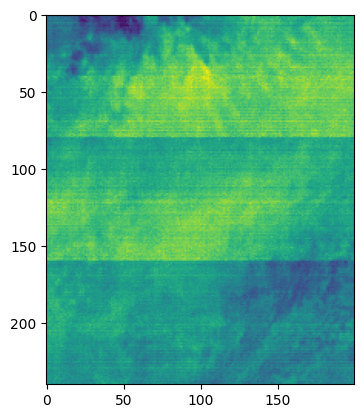

In [572]:
plt.imshow(b6_image_corrected[480:720, 4000:4200])

In [312]:
plt.imsave('b6_corr_full.png', b6_image_corrected)

In [380]:
voc_b6_data_corrected = apply_coeff_for_telemetry(voc_b6_data, alpha, beta)
bb_b6_data_corrected = apply_coeff_for_telemetry(bb_b6_data, alpha, beta)
sv_b6_data_corrected = apply_coeff_for_telemetry(sv_b6_data, alpha, beta)

In [28]:
bb_b6_data_1_mirror = bb_b6_data[::2]
bb_b6_data_2_mirror = bb_b6_data[1::2]

In [29]:
bb_b6_data_1_mirror_corr = bb_b6_data_corrected[::2]
bb_b6_data_2_mirror_corr = bb_b6_data_corrected[1::2]

In [30]:
sv_b6_data_1_mirror = sv_b6_data[::2]
sv_b6_data_2_mirror = sv_b6_data[1::2]

In [31]:
sv_b6_data_1_mirror_corr = sv_b6_data_corrected[::2]
sv_b6_data_2_mirror_corr = sv_b6_data_corrected[1::2]

In [488]:
voc_b6_data_1_mirror = voc_b6_data[::2]
voc_b6_data_2_mirror = voc_b6_data[1::2]

In [33]:
voc_b6_data_1_mirror_corr = voc_b6_data_corrected[::2]
voc_b6_data_2_mirror_corr = voc_b6_data_corrected[1::2]

In [34]:
b6_image_1_mirror_corr = b6_image_corrected[::2]
b6_image_2_mirror_corr = b6_image_corrected[1::2]

In [501]:
np.mean(bb_b6_data_1_mirror_corr, axis=(0, 1)).shape

(48,)

In [505]:
diff = np.mean(bb_b6_data_1_mirror_corr, axis=(0, 1)) - np.mean(bb_b6_data_2_mirror_corr, axis=(0, 1))

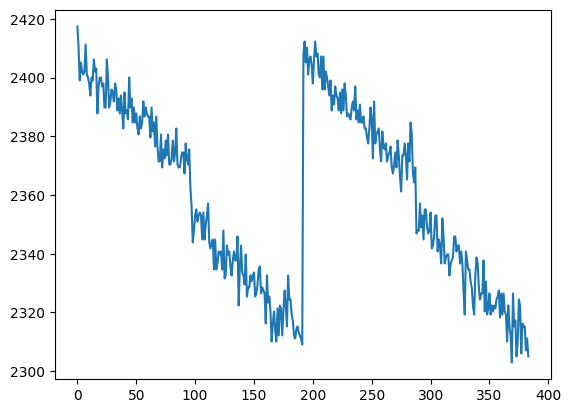

In [538]:
plt.plot(np.arange(96 * 4), np.concatenate([voc_b6_data_1_mirror_corr[0][0], voc_b6_data_2_mirror_corr[0][0],
                                            voc_b6_data_1_mirror_corr[2][0], voc_b6_data_2_mirror_corr[2][0],]))

In [507]:
np.mean(bb_b6_data_1_mirror_corr, axis=(0, 1)) - np.mean(bb_b6_data_2_mirror_corr, axis=(0, 1))

array([1259.78208739, 1258.88501247, 1259.16761407, 1259.1890094 ,
       1259.85237361, 1259.02935819, 1259.12376467, 1259.12318915,
       1259.69480025, 1258.98415122, 1259.09798643, 1259.14195717,
       1259.79434879, 1258.89464584, 1259.13757097, 1259.07916781,
       1259.74628039, 1258.89986078, 1259.0684967 , 1259.24445054,
       1259.72177414, 1258.93254624, 1259.05191521, 1259.10812076,
       1259.79034463, 1258.99347054, 1259.06905446, 1259.02390088,
       1259.78996341, 1258.93515755, 1259.08069429, 1259.0412456 ,
       1259.75430783, 1258.9789596 , 1259.10931188, 1259.01421306,
       1259.72781675, 1258.99662987, 1259.00188825, 1259.16279711,
       1259.72187698, 1258.97426611, 1259.16795294, 1259.0590691 ,
       1259.74998359, 1258.91792708, 1259.15359238, 1259.0569536 ])

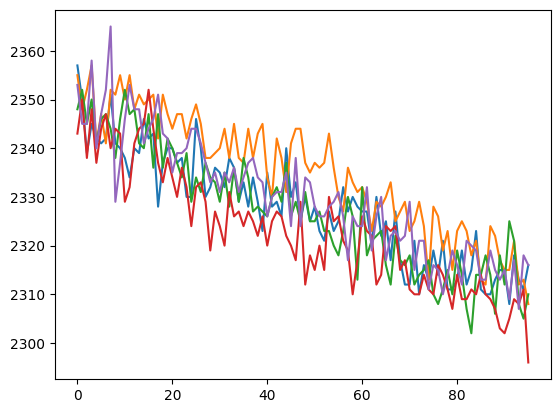

In [52]:
for i in range(0, 10, 2):
    plt.plot(np.arange(96), voc_b6_data[i][0])

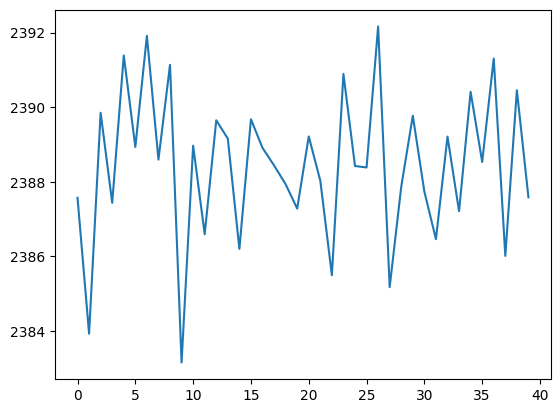

In [35]:
plt.plot(np.arange(40), np.mean(voc_b6_data_1_mirror_corr[0], axis=1))

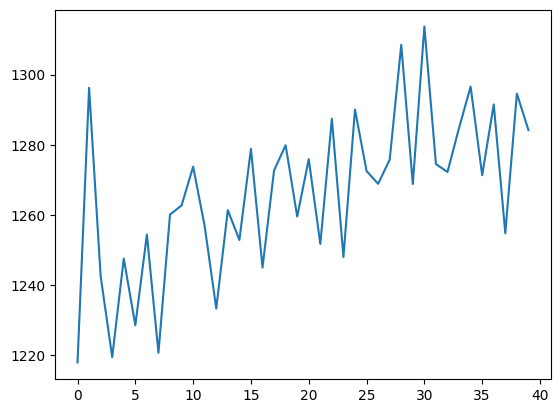

In [291]:
plt.plot(np.arange(40), np.mean(bb_b6_data_2_mirror[0], axis=1))

In [292]:
bb_b7_data_1_mirror = bb_b7_data[::2]
bb_b7_data_2_mirror = bb_b7_data[1::2]

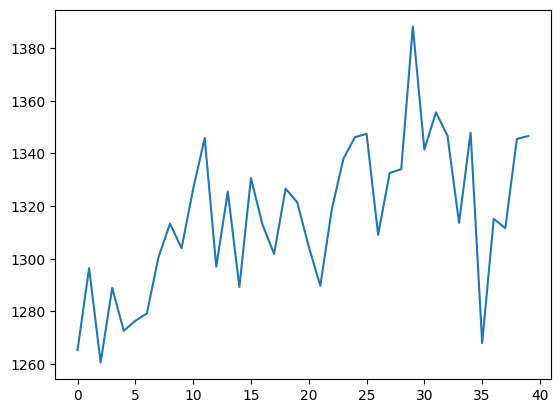

In [308]:
plt.plot(np.arange(40), np.mean(bb_b7_data_2_mirror[1], axis=1))

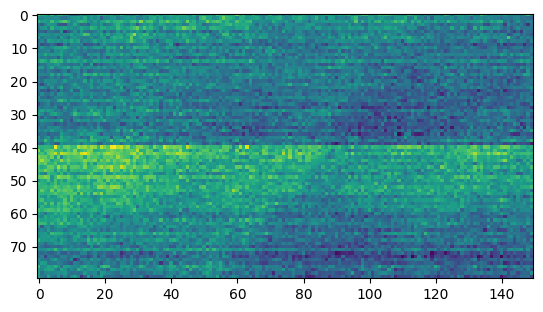

In [333]:
plt.imshow(b6_image_corrected[520:600, 5100:5250])

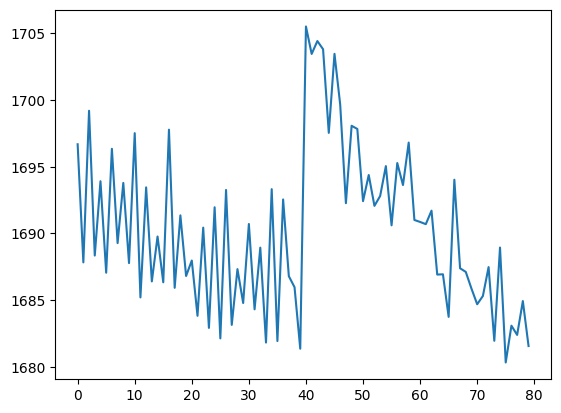

In [331]:
plt.plot(np.arange(80), np.mean(b6_image_corrected[440:520, 5100:5250], axis=1))

In [318]:
np.mean(b6_image_corrected[440:520, 5100:5250])

1690.2760833333334

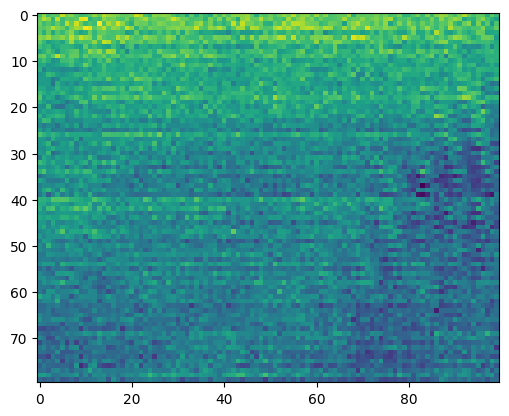

In [330]:
plt.imshow(b6_image_corrected[480:560, 5200:5300])

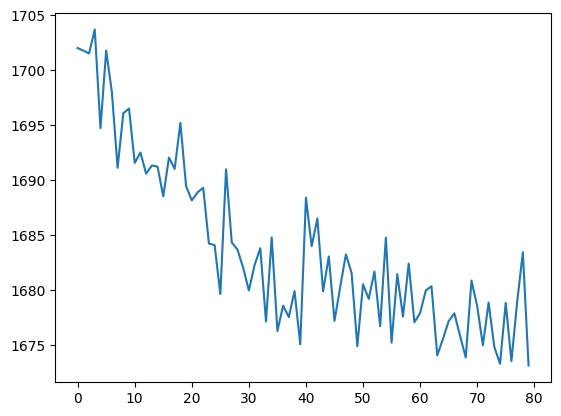

In [329]:
plt.plot(np.arange(80), np.mean(b6_image_corrected[480:560, 5200:5300], axis=1))

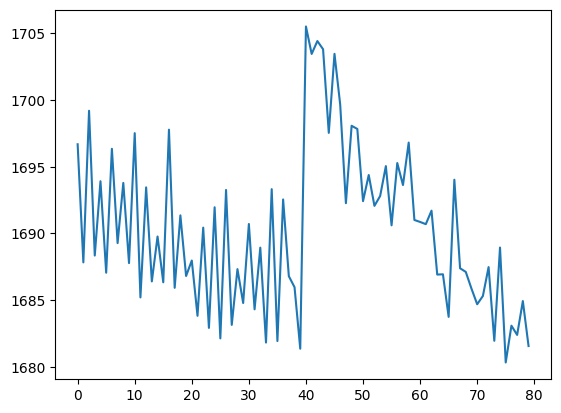

In [290]:
plt.plot(np.arange(80), np.mean(b6_image_corrected[440:520, 5100:5250], axis=1))

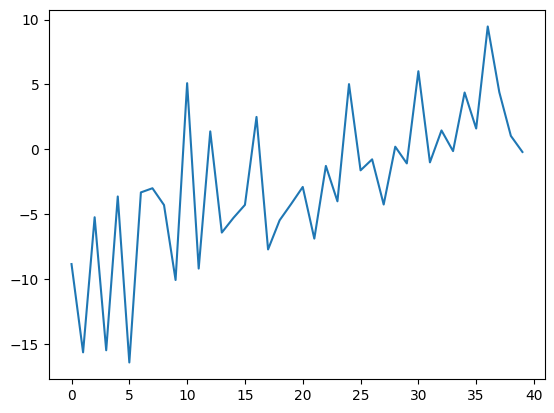

In [275]:
plt.plot(np.arange(40), np.mean(b6_image_corrected[440:480, 5100:5250], axis=1) - np.mean(b6_image_corrected[480:520, 5100:5250], axis=1))

In [276]:
diff = np.mean(b6_image_corrected[440:480, 5100:5250], axis=1) - np.mean(b6_image_corrected[480:520, 5100:5250], axis=1)

In [277]:
np.mean(diff)

-2.74616666666667

In [271]:
np.mean(b6_image_corrected[480:520, 5100:5250])

1691.6491666666666

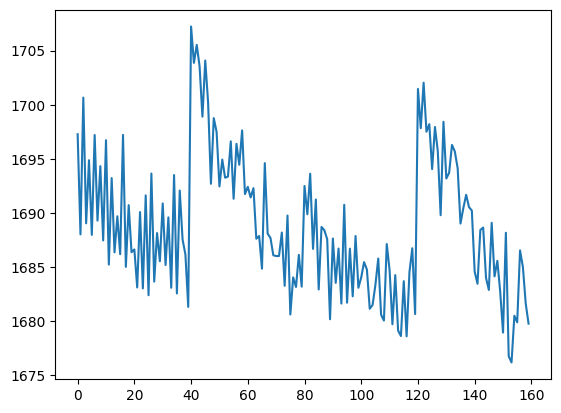

In [265]:
plt.plot(np.arange(160), np.mean(b6_image_corrected[440:600, 5100:5200], axis=1))

In [ ]:
plt.plot(np.arange(40), np.mean(b6_image_1_mirror_corr[0], axis=1))

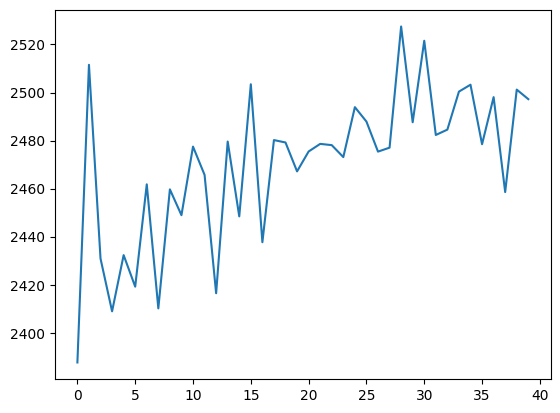

In [184]:
plt.plot(np.arange(40), np.mean(voc_b6_data_1_mirror_corr[0], axis=1))

In [40]:
a, b = np.polyfit(np.arange(40), np.mean(bb_b6_data_1_mirror_corr[0], axis=1), 1)
poly1d_fn = np.poly1d((a, b))

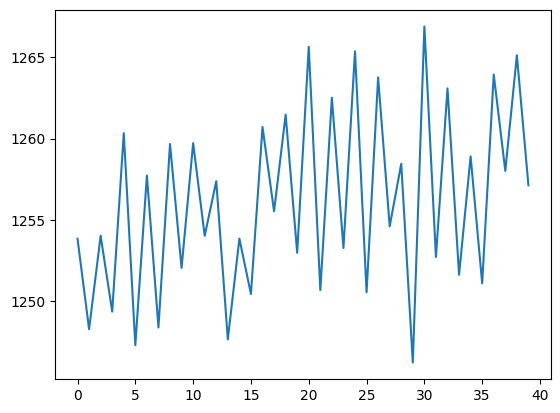

In [62]:
plt.plot(np.arange(40), np.mean(bb_b6_data_2_mirror_corr[0], axis=1))
#plt.plot(np.arange(40), np.repeat(np.mean(bb_b6_data_1_mirror_corr[0]), 40))

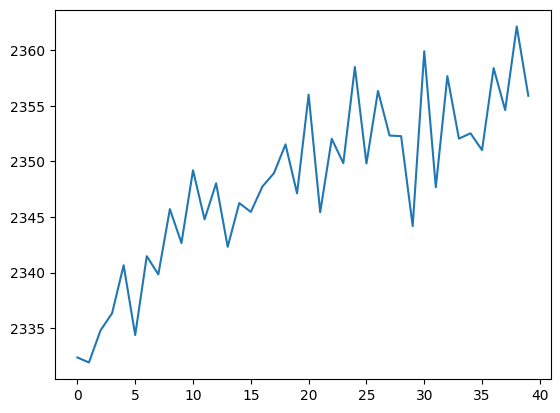

In [64]:
plt.plot(np.arange(40), np.mean(voc_b6_data_2_mirror_corr[0], axis=1))
#plt.plot(np.arange(40), np.repeat(np.mean(voc_b6_data_2_mirror_corr[0]), 40))

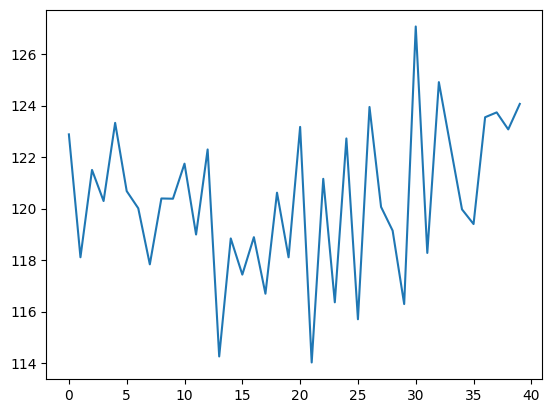

In [71]:
plt.plot(np.arange(40), np.mean(sv_b6_data_2_mirror_corr[0], axis=1))

In [94]:
alpha_2, beta_2 = coeff_calulation(np.mean(sv_b6_data_2_mirror_corr[0]), np.mean(voc_b6_data_2_mirror_corr[0]), np.mean(sv_b6_data_2_mirror_corr[0], axis=1), np.mean(voc_b6_data_2_mirror_corr[0], axis=1))

In [95]:
alpha_2 = np.vstack([np.ones(alpha_2.shape[0]), alpha_2])
beta_2 = np.vstack([np.zeros(beta_2.shape[0]), beta_2])

In [96]:
alpha_2

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.00824371, 1.00627508, 1.00650507, 1.00525675, 1.00467425,
        1.00631961, 1.00280462, 1.00256144, 1.00106958, 1.0024393 ,
        1.00010606, 1.00085484, 1.00087909, 0.99983677, 1.00012737,
        0.99985443, 0.99948422, 0.9979607 , 0.99855818, 0.9994085 ,
        0.99769696, 0.99833699, 0.99857387, 0.9974092 , 0.99638968,
        0.99712738, 0.99789578, 0.99795248, 0.99756745, 0.9999123 ,
        0.99769708, 0.99923439, 0.99773284, 0.9

In [91]:
alpha_2.shape

(80,)

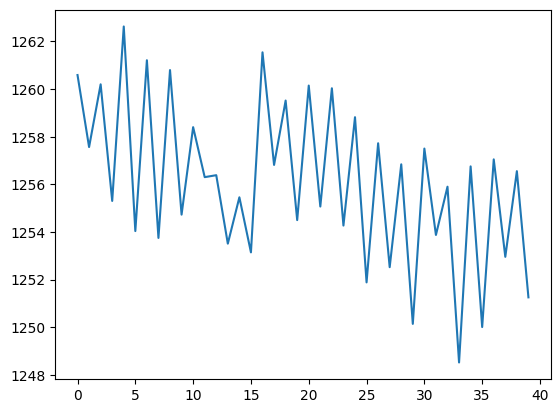

In [78]:
plt.plot(np.arange(40), alpha_2 * np.mean(bb_b6_data_2_mirror_corr[0], axis=1) + beta_2)

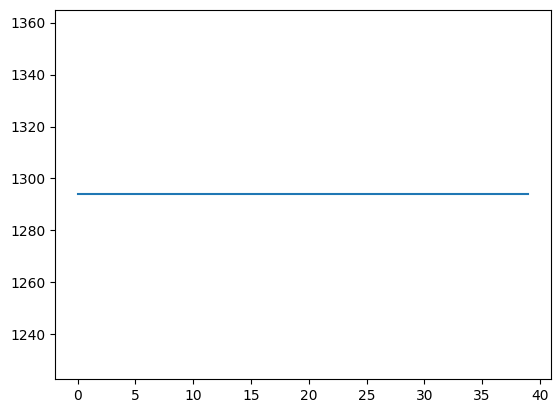

In [57]:
plt.plot(np.arange(40), alpha_2 * np.mean(bb_b6_data_1_mirror_corr[0], axis=1) + beta_2)

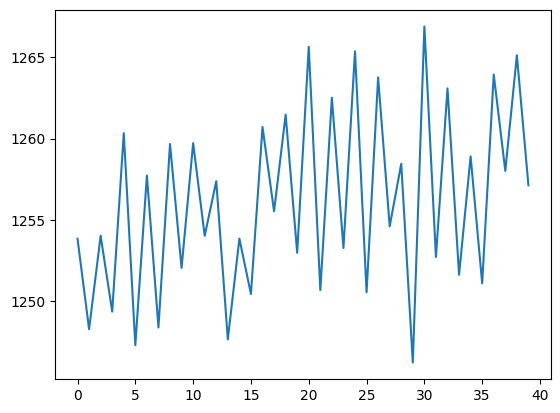

In [32]:
plt.plot(np.arange(40), np.mean(bb_b6_data_2_mirror_corr[0], axis=1))

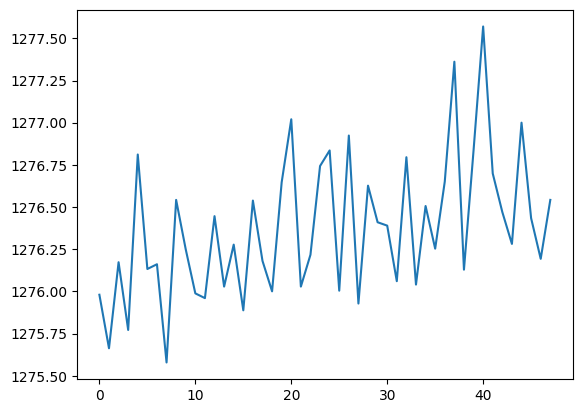

In [33]:
plt.plot(np.arange(48), np.mean(bb_b6_data_1_mirror[:, ::40, :], axis=(0, 1)))

In [34]:
voc_b6_data_1_mirror = voc_b6_data[::2]
voc_b6_data_2_mirror = voc_b6_data[1::2]

In [37]:
voc_b6_data_1_mirror_corr = voc_b6_data_corrected[::2]
voc_b6_data_2_mirror_corr = voc_b6_data_corrected[1::2]

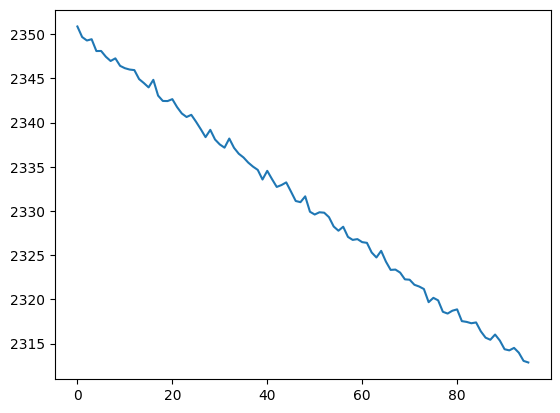

In [36]:
plt.plot(np.arange(96), np.mean(voc_b6_data_1_mirror[:, ::40, :], axis=(0, 1)))

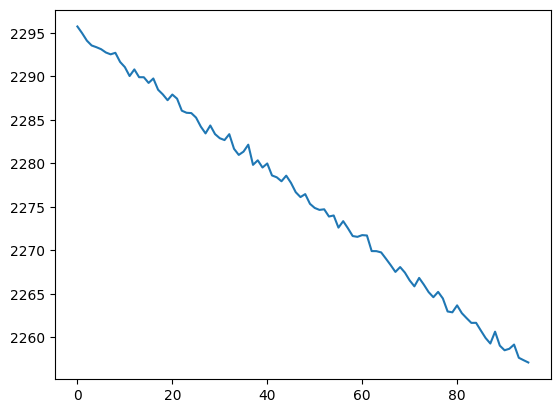

In [35]:
plt.plot(np.arange(96), np.mean(voc_b6_data_2_mirror[:, ::40, :], axis=(0, 1)))

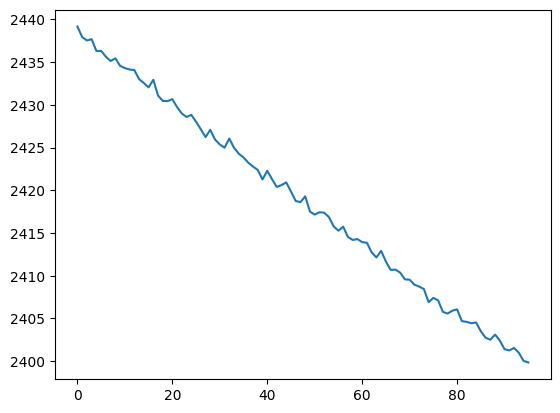

In [38]:
plt.plot(np.arange(96), np.mean(voc_b6_data_1_mirror_corr[:, ::40, :], axis=(0, 1)))

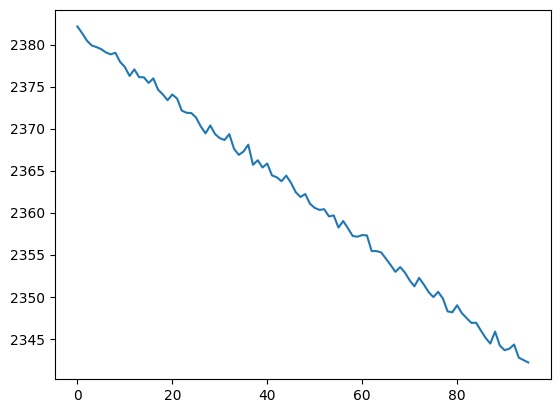

In [39]:
plt.plot(np.arange(96), np.mean(voc_b6_data_2_mirror_corr[:, ::40, :], axis=(0, 1)))

In [76]:
sv_b6_data_1_mirror = sv_b6_data[::2]
sv_b6_data_2_mirror = sv_b6_data[1::2]

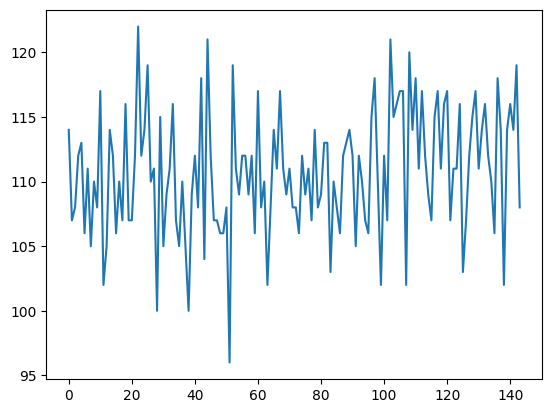

In [82]:
plt.plot(np.arange(144), sv_b6_data_2_mirror[:, ::40, :][0][0])

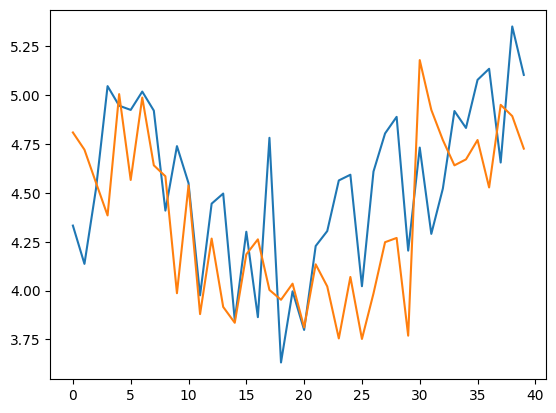

In [96]:
plt.plot(np.arange(40), np.std(sv_b6_data_1_mirror[0, :, :], axis=1))
plt.plot(np.arange(40), np.std(sv_b6_data_2_mirror[0, :, :], axis=1))

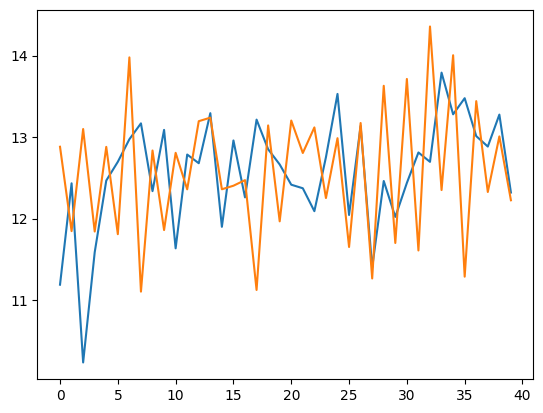

In [97]:
plt.plot(np.arange(40), np.std(voc_b6_data_1_mirror[0, :, :], axis=1))
plt.plot(np.arange(40), np.std(voc_b6_data_2_mirror[0, :, :], axis=1))

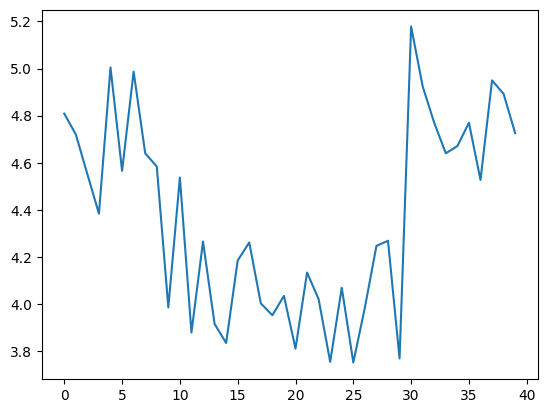

In [92]:
plt.plot(np.arange(40), np.std(sv_b6_data_2_mirror[0, :, :], axis=1))

In [80]:
np.std()

0.0

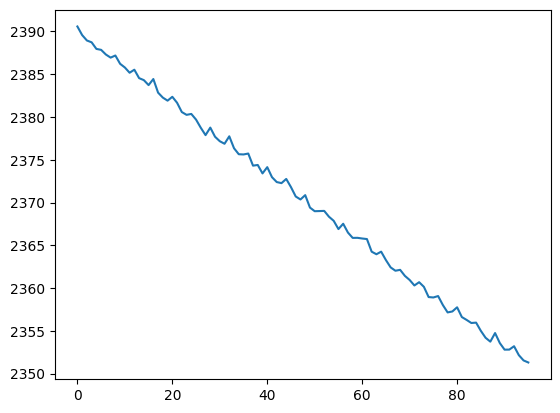

In [67]:
plt.plot(np.arange(96), np.mean(voc_b6_data_corrected[:, ::40, :], axis=(0, 1)))

In [61]:
np.std(voc_b6_data[:, ::40, :], axis=(0, 2))

array([30.19185892])

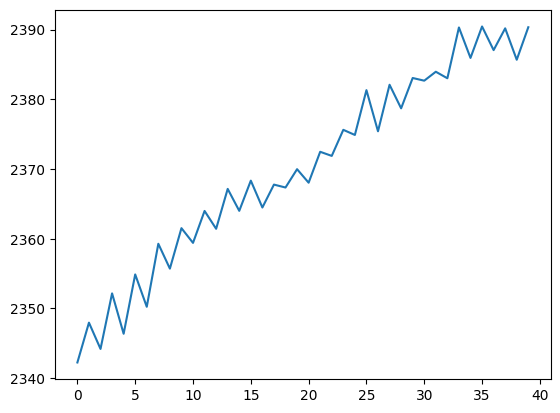

In [45]:
plt.plot(np.arange(40), np.mean(voc_b6_data_corrected[1::2], axis=(0, 2)))

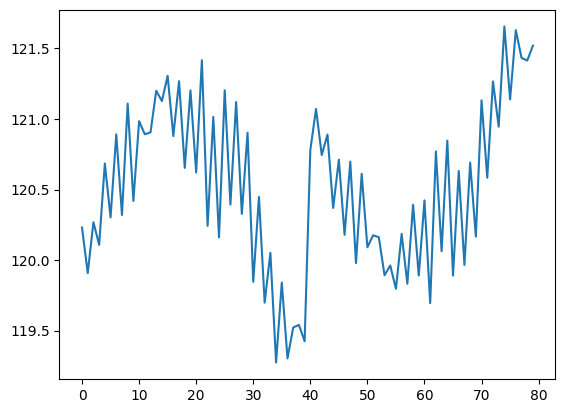

In [115]:
plt.plot(np.arange(80), np.concatenate([np.mean(sv_b6_data_corrected[::2], axis=(0, 2)), np.mean(sv_b6_data_corrected[1::2], axis=(0, 2))]))

In [58]:
bb_b6_data_corrected = apply_coeff_for_telemetry(bb_b6_data, alpha, beta)

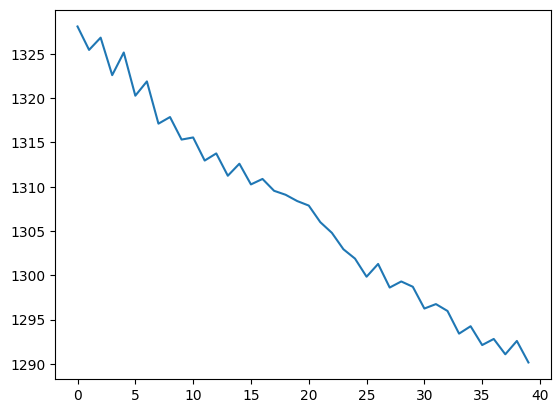

In [59]:
plt.plot(np.arange(40), np.mean(bb_b6_data_corrected[::2], axis=(0, 2)))

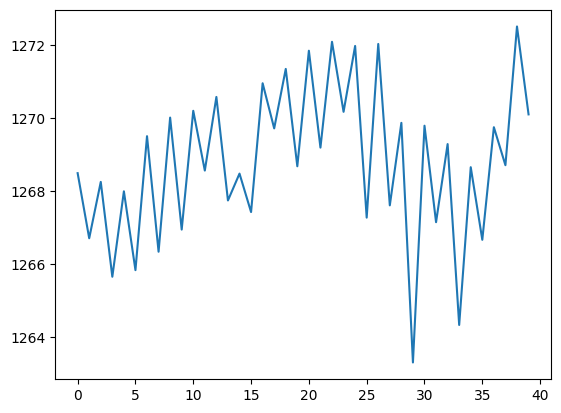

In [60]:
plt.plot(np.arange(40), np.mean(bb_b6_data_corrected[1::2], axis=(0, 2)))

In [78]:
voc_b6_data_corrected = np.zeros(voc_b6_data.shape)

for i in range(voc_b6_data.shape[0]):
    voc_b6_data_corrected[i] = alpha[..., None][(i // 40) % 2] * voc_b6_data[i] + beta[..., None][(i // 40) % 2]

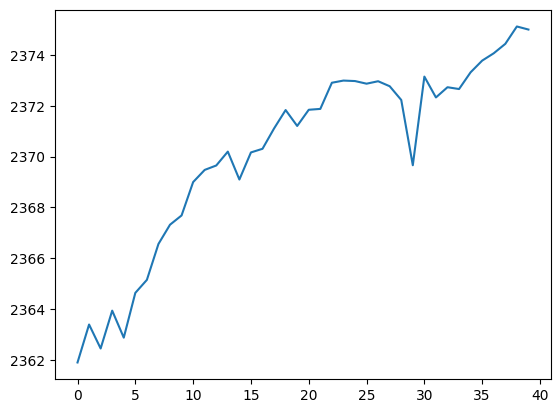

In [79]:
plt.plot(np.arange(40), np.mean(voc_b6_data_corrected[1::2], axis=(0, 2)))

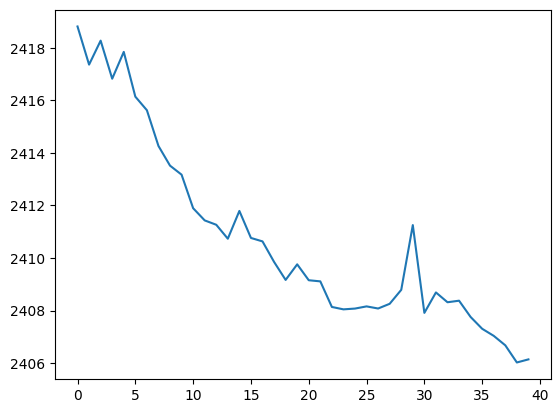

In [80]:
plt.plot(np.arange(40), np.mean(voc_b6_data_corrected[::2], axis=(0, 2)))

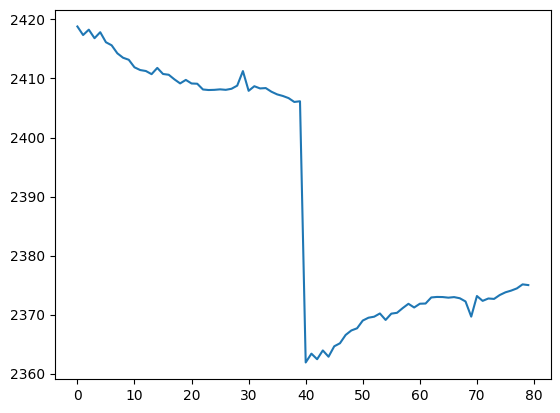

In [82]:
plt.plot(np.arange(80), np.concatenate([np.mean(voc_b6_data_corrected[::2], axis=(0, 2)), np.mean(voc_b6_data_corrected[1::2], axis=(0, 2))]))

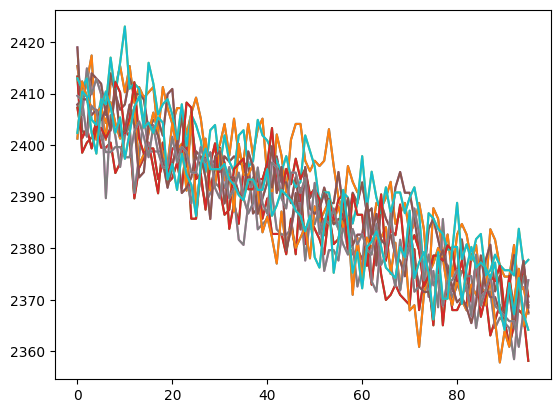

In [102]:
for i in range(10):
    plt.plot(np.arange(96), voc_b6_data_corrected[2][i])
    plt.plot(np.arange(96), voc_b6_data_corrected[2][i])

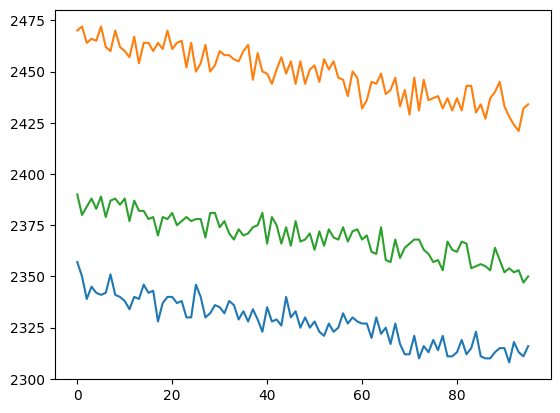

In [100]:
for i in range(3):
    plt.plot(np.arange(96), voc_b6_data[0][i])

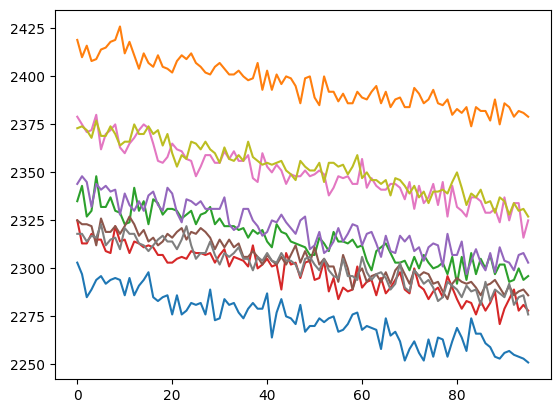

In [170]:
for i in range(9):
    plt.plot(np.arange(96), voc_b6_data[1][i])

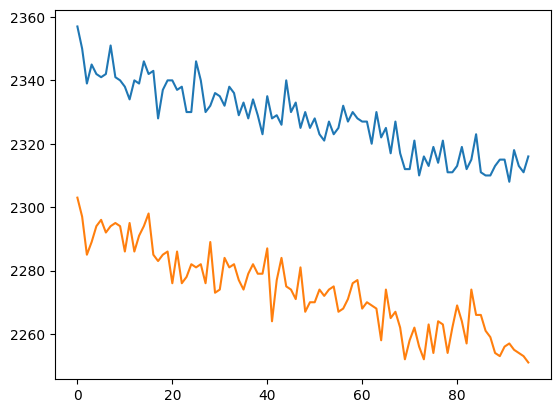

In [171]:
plt.plot(np.arange(96), voc_b6_data[0][0])
plt.plot(np.arange(96), voc_b6_data[1][0])

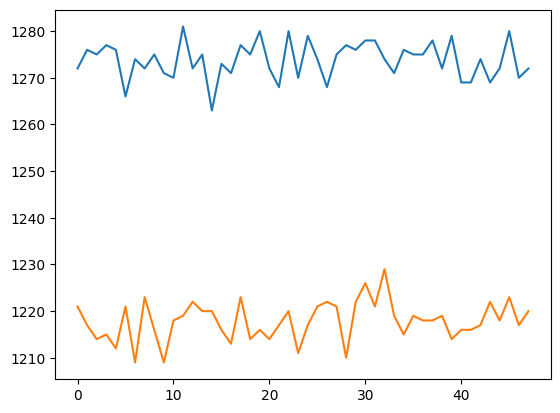

In [172]:
plt.plot(np.arange(48), bb_b6_data[0][0])
plt.plot(np.arange(48), bb_b6_data[1][0])

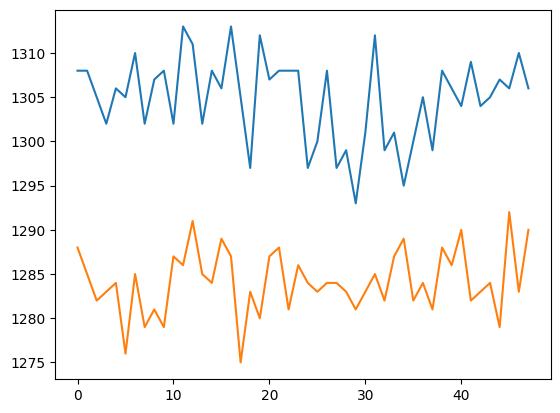

In [173]:
plt.plot(np.arange(48), bb_b6_data[0][39])
plt.plot(np.arange(48), bb_b6_data[1][39])

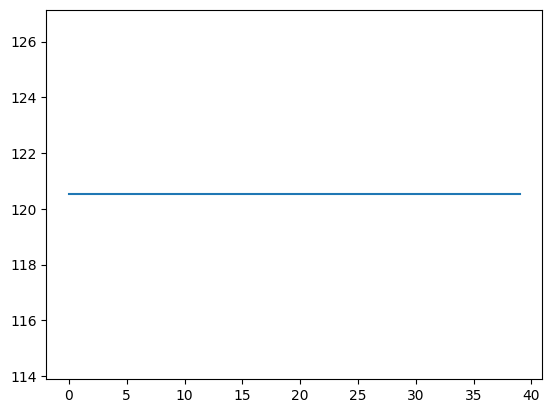

In [83]:
plt.plot(np.arange(40), sv_b6_sensors_mean[1] * alpha[1] + beta[1])

In [178]:
np.mean(sv_b6_sensors_mean[1] * alpha[1] + beta[1])

120.51761594991076

In [179]:
np.mean(sv_b6_sensors_mean[0] * alpha[0] + beta[0])

120.51761594991076

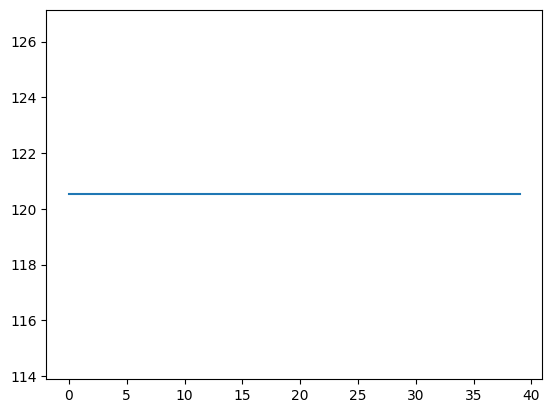

In [84]:
plt.plot(np.arange(40), sv_b6_sensors_mean[1] * alpha[1] + beta[1])

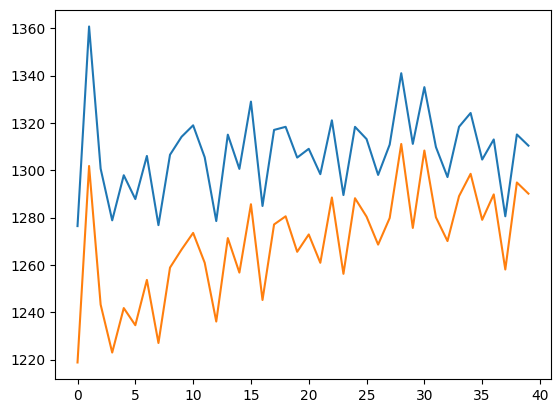

In [105]:
plt.plot(np.arange(40), bb_b6_sensors_mean[0])
plt.plot(np.arange(40), bb_b6_sensors_mean[1])

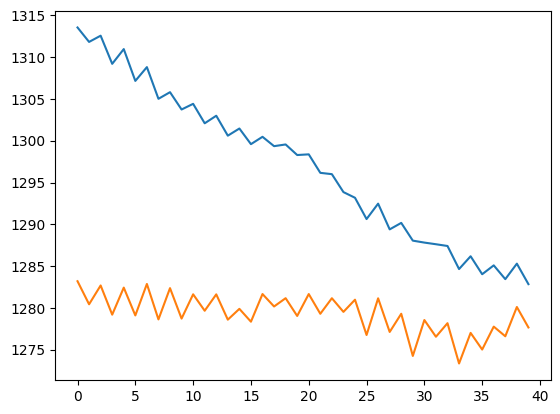

In [104]:
plt.plot(np.arange(40), bb_b6_sensors_mean[0] * alpha[0] + beta[0])
plt.plot(np.arange(40), bb_b6_sensors_mean[1] * alpha[1] + beta[1])
#plt.yticks(np.arange(np.min(voc_b6_sensors_mean[1] * alpha[0] + beta[0]), np.max(voc_b6_sensors_mean[0] * alpha[1] + beta[1]), 10))

([<matplotlib.axis.YTick at 0x25727bd6250>,
 [Text(0, 2287.787739511697, '2287.8'),
  Text(0, 2297.787739511697, '2297.8'),
  Text(0, 2307.787739511697, '2307.8'),
  Text(0, 2317.787739511697, '2317.8'),
  Text(0, 2327.787739511697, '2327.8'),
  Text(0, 2337.787739511697, '2337.8'),
  Text(0, 2347.787739511697, '2347.8'),
  Text(0, 2357.787739511697, '2357.8'),
  Text(0, 2367.787739511697, '2367.8'),
  Text(0, 2377.787739511697, '2377.8'),
  Text(0, 2387.787739511697, '2387.8'),
  Text(0, 2397.787739511697, '2397.8'),
  Text(0, 2407.787739511697, '2407.8'),
  Text(0, 2417.787739511697, '2417.8'),
  Text(0, 2427.787739511697, '2427.8'),
  Text(0, 2437.787739511697, '2437.8'),
  Text(0, 2447.787739511697, '2447.8'),
  Text(0, 2457.787739511697, '2457.8')])

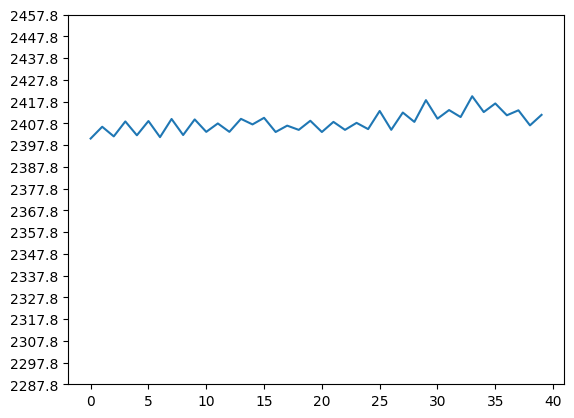

In [174]:
plt.plot(np.arange(40), voc_b6_sensors_mean[1] * alpha[1] + beta[1])
plt.yticks(np.arange(np.min(voc_b6_sensors_mean[1] * alpha[0] + beta[0]), np.max(voc_b6_sensors_mean[0] * alpha[1] + beta[1]), 10))

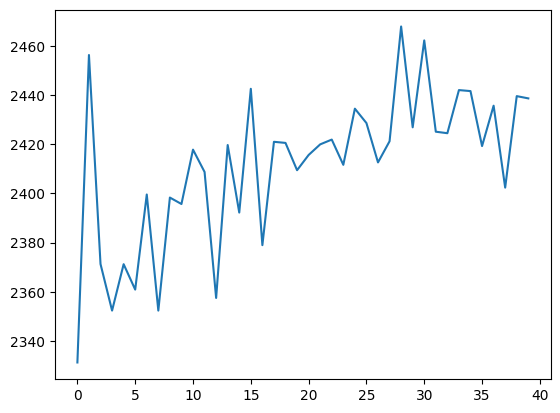

In [103]:
plt.plot(np.arange(40), voc_b6_sensors_mean[0])

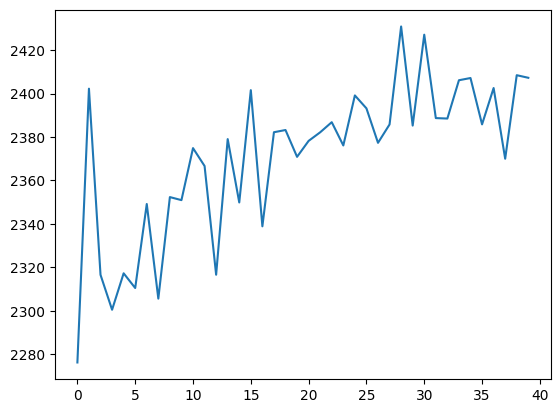

In [120]:
plt.plot(np.arange(40), voc_b6_sensors_mean[1])

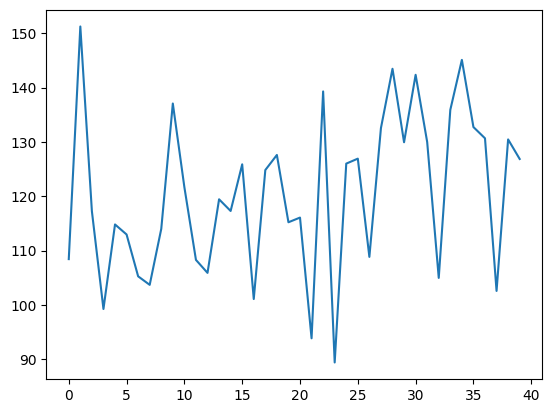

In [125]:
plt.plot(np.arange(40), sv_b6_sensors_mean[0])

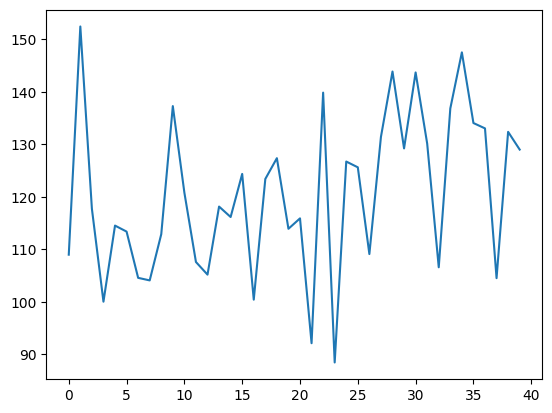

In [126]:
plt.plot(np.arange(40), sv_b6_sensors_mean[1])

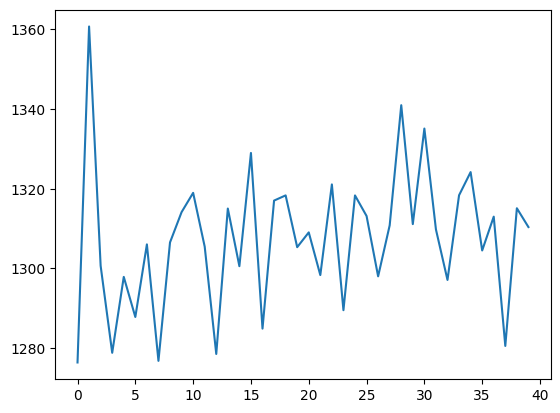

In [127]:
plt.plot(np.arange(40), bb_b6_sensors_mean[0])

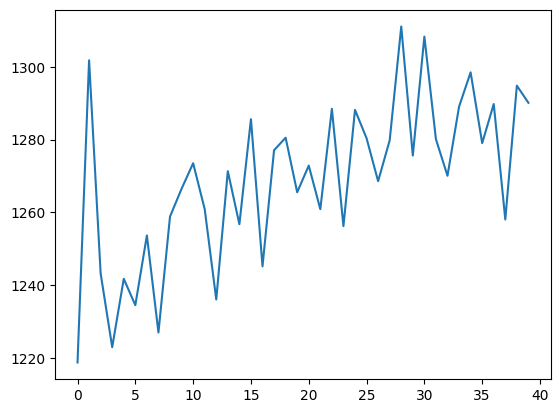

In [128]:
plt.plot(np.arange(40), bb_b6_sensors_mean[1])

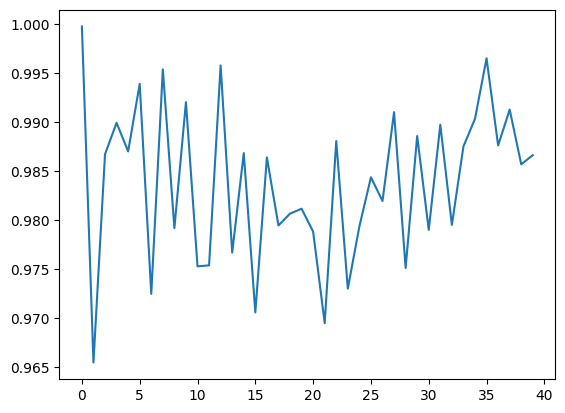

In [129]:
plt.plot(np.arange(40), alpha[0])

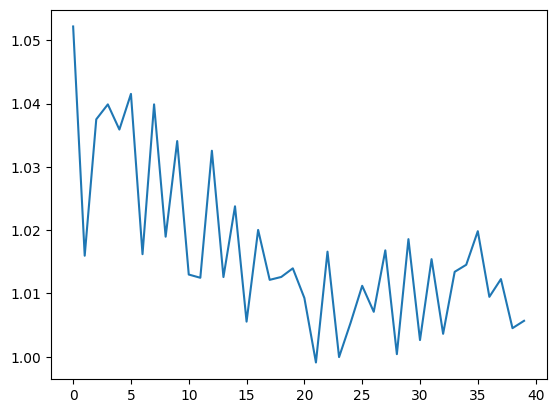

In [130]:
plt.plot(np.arange(40), alpha[1])

In [ ]:
plt.plot(np.arange(40), beta[0])
plt.yticks(np.arange(np.min(beta), np.max(beta), 10))

In [ ]:
plt.plot(np.arange(40), beta[1])
plt.yticks(np.arange(np.min(beta), np.max(beta), 10))

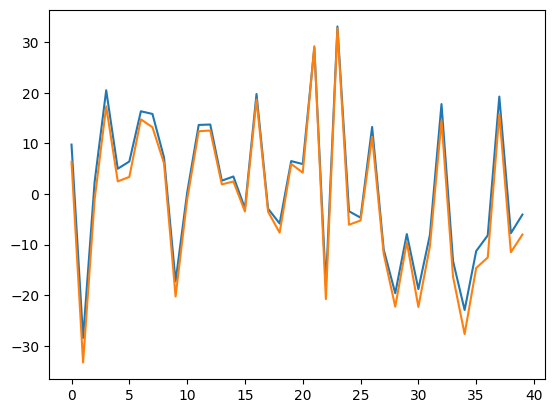

In [121]:
plt.plot(np.arange(40), beta[0])
plt.plot(np.arange(40), beta[1])

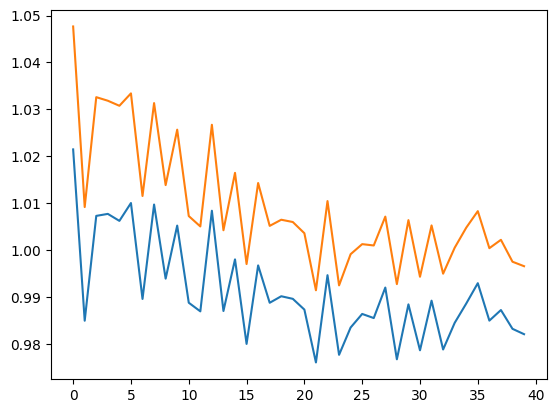

In [120]:
plt.plot(np.arange(40), alpha[0])
plt.plot(np.arange(40), alpha[1])

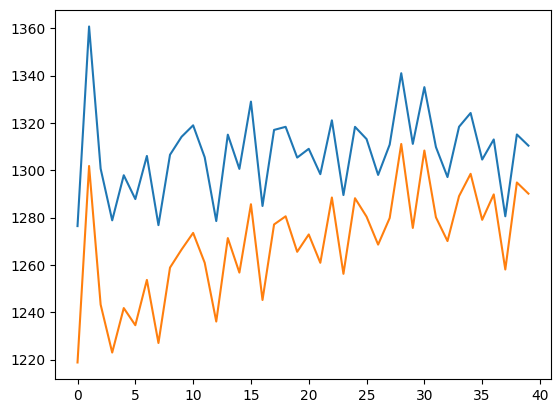

In [122]:
plt.plot(np.arange(40), bb_b6_sensors_mean[0])
plt.plot(np.arange(40), bb_b6_sensors_mean[1])

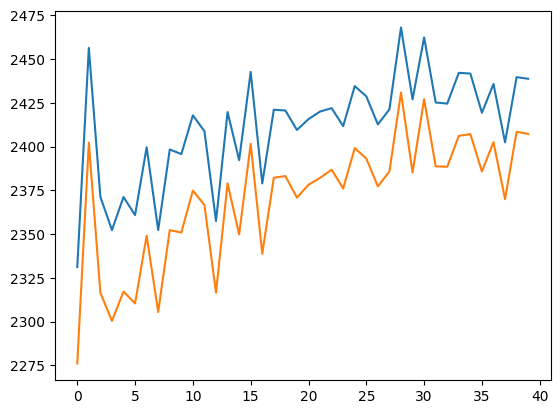

In [123]:
plt.plot(np.arange(40), voc_b6_sensors_mean[0])
plt.plot(np.arange(40), voc_b6_sensors_mean[1])

In [124]:
section_1_corrected[80:120].shape

(40, 6144)

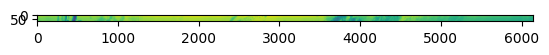

In [125]:
plt.imshow(section_1_corrected[80:160])

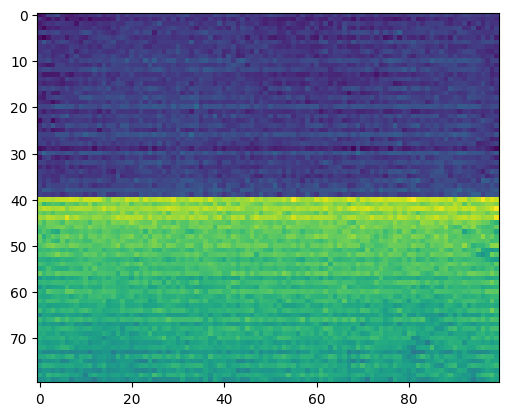

In [126]:
plt.imshow(section_1_corrected[120:200][:, 1450:1550])

In [228]:
diff = section_1_corrected[120:160][:, 1450:1550] - section_1_corrected[160:200][:, 1450:1550]

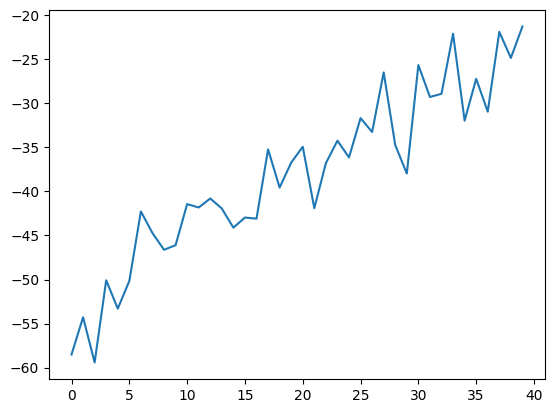

In [229]:
plt.plot(np.arange(40), np.mean(diff, axis=1))

In [212]:
bb_diff = bb_b6_data_corrected[0] - bb_b6_data_corrected[1]

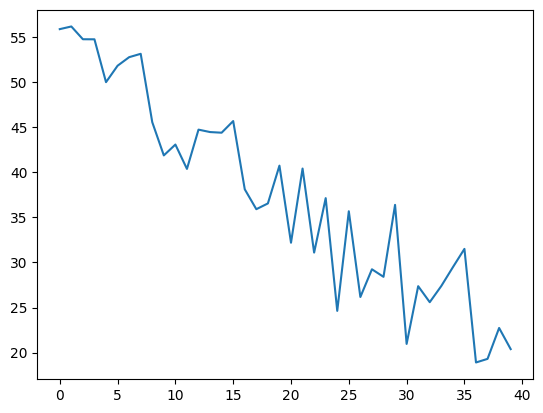

In [213]:
plt.plot(np.arange(40), np.mean(bb_diff, axis=1))

In [201]:
np.mean(diff, axis=1).shape

(40,)

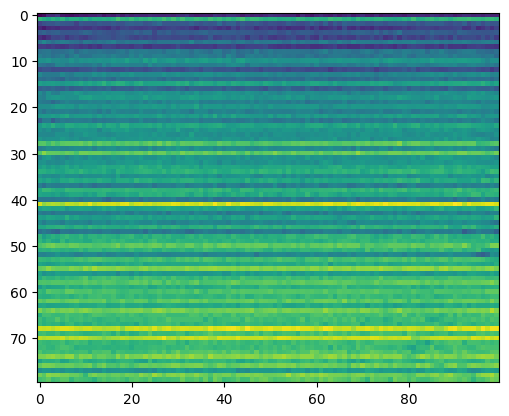

In [219]:
plt.imshow(section_1[120:200][:, 1450:1550])

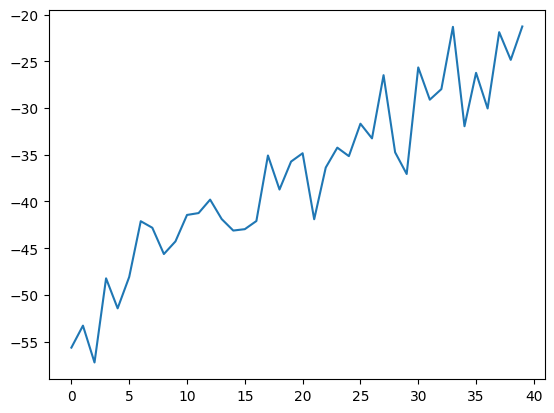

In [222]:
diff = section_1[120:160][:, 1450:1550].astype(dtype=np.int16) - section_1[160:200][:, 1450:1550].astype(dtype=np.int16)
plt.plot(np.arange(40), np.mean(diff, axis=1))

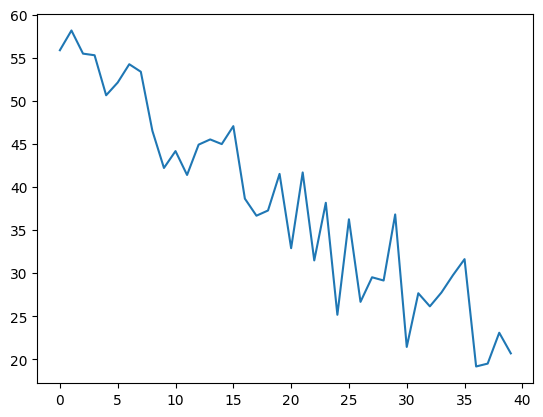

In [224]:
bb_diff = bb_b6_data[0].astype(dtype=np.int16) - bb_b6_data[1].astype(dtype=np.int16)
plt.plot(np.arange(40), np.mean(bb_diff, axis=1))